# 第4章: 形態素解析

夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt)）をMeCabを使って形態素解析し，その結果をneko.txt.mecabというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

なお，問題37, 38, 39は[matplotlib](http://matplotlib.org/)もしくは[Gnuplot](http://www.gnuplot.info/)を用いるとよい．

In [1]:
from os import environ

environ["NEKO_TXT"] = "./data/chapter04/neko.txt"
environ["NEKO_TXT_MECAB"] = neko_txt_mecab = "./data/chapter04/neko.txt.mecab"

!test -f $NEKO_TXT_MECAB || \
{ mkdir -p $(dirname $NEKO_TXT_MECAB) && \
  curl -o $NEKO_TXT http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt && \
  mecab -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -o $NEKO_TXT_MECAB $NEKO_TXT; }

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  943k  100  943k    0     0  2849k      0 --:--:-- --:--:-- --:--:-- 2849k


## 30. 形態素解析結果の読み込み

形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ．ただし，各形態素は表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をキーとするマッピング型に格納し，1文を形態素（マッピング型）のリストとして表現せよ．第4章の残りの問題では，ここで作ったプログラムを活用せよ．

In [2]:
from pprint import pprint

# MeCab format: 表層形 \t 品詞, 品詞細分類1, 品詞細分類2, 品詞細分類3, 活用型, 活用形, 原形, 読み, 発音
mecab_list = []
with open(neko_txt_mecab, 'r', encoding='utf-8') as f:
    sentence = []
    for l in f:
        if l.strip() == 'EOS':
            if len(sentence):
                mecab_list.append(sentence.copy())
                sentence = []
            continue
        
        surface, others = l.split('\t', maxsplit=1)
        others = others.split(',', maxsplit=8)
        sentence.append({
            'surface': surface,
            'base': others[6],
            'pos': others[0],
            'pos1': others[1]
        })

pprint(mecab_list[:3])

[[{'base': '一', 'pos': '名詞', 'pos1': '数', 'surface': '一'}],
 [{'base': '\u3000', 'pos': '記号', 'pos1': '空白', 'surface': '\u3000'},
  {'base': '吾輩は猫である', 'pos': '名詞', 'pos1': '固有名詞', 'surface': '吾輩は猫である'},
  {'base': '。', 'pos': '記号', 'pos1': '句点', 'surface': '。'}],
 [{'base': '名前', 'pos': '名詞', 'pos1': '一般', 'surface': '名前'},
  {'base': 'は', 'pos': '助詞', 'pos1': '係助詞', 'surface': 'は'},
  {'base': 'まだ', 'pos': '副詞', 'pos1': '助詞類接続', 'surface': 'まだ'},
  {'base': '無い', 'pos': '形容詞', 'pos1': '自立', 'surface': '無い'},
  {'base': '。', 'pos': '記号', 'pos1': '句点', 'surface': '。'}]]


## 31. 動詞

動詞の表層形をすべて抽出せよ．

In [3]:
verb_surfaces = set()
for s in mecab_list:
    [verb_surfaces.add(m['surface']) for m in s if m['pos'] == '動詞']

print("verb_surfaces:", len(verb_surfaces))

verb_surfaces: 3811


## 32. 動詞の原形

動詞の原形をすべて抽出せよ．

In [4]:
verb_bases = set()
for s in mecab_list:
    [verb_bases.add(m['base']) for m in s if m['pos'] == '動詞']

print("verb_bases:", len(verb_bases))

verb_bases: 2259


## 33. サ変名詞

サ変接続の名詞をすべて抽出せよ．

In [5]:
noun_bases = set()
for s in mecab_list:
    [noun_bases.add(m['base']) for m in s if m['pos1'] == 'サ変接続']

print("noun_bases:", len(noun_bases))

noun_bases: 1293


## 34. 「AのB」

2つの名詞が「の」で連結されている名詞句を抽出せよ．

In [6]:
noun_phrases = set()
for s in mecab_list:
    if len(s) < 3:
        continue
    
    for i in range(len(s)-2):
        m0, m1, m2 = s[i:i+3]
        if m0['pos'] == m2['pos'] == "名詞" and m1['surface'] == "の":
            noun_phrases.add("{}の{}".format(m0['surface'], m2['surface']))
            break

print("noun_phrases:", len(noun_phrases))

noun_phrases: 3132


## 35. 名詞の連接

名詞の連接（連続して出現する名詞）を最長一致で抽出せよ

In [7]:
continuous_nouns_set = set()
for s in mecab_list:
    sentence_length = len(s)
    for i in range(sentence_length-1):
        if not s[i]['pos'] == "名詞":
            continue
        
        cnouns = s[i]['surface']
        offset = 1
        while i+offset < sentence_length:
            next_morpheme = s[i+offset]
            if not next_morpheme['pos'] == "名詞":
                break
            cnouns = next_morpheme['surface']
            offset += 1
        
        if offset > 1:
            continuous_nouns_set.add(cnouns)

print("continuous_nouns_set:", len(continuous_nouns_set))

continuous_nouns_set: 1994


## 36. 単語の出現頻度

文章中に出現する単語とその出現頻度を求め，出現頻度の高い順に並べよ．

In [8]:
from pprint import pprint

word_freq = {}
for s in mecab_list:
    for m in s:
        surface = m['surface']
        if surface in word_freq.keys():
            word_freq[surface] += 1
        else:
            word_freq[surface] = 1

word_freq = sorted(word_freq.items(), key=lambda kv: kv[1], reverse=True)
pprint(word_freq[:10])

[('の', 9106),
 ('。', 7484),
 ('、', 6772),
 ('て', 6697),
 ('は', 6384),
 ('に', 6147),
 ('を', 6068),
 ('と', 5474),
 ('が', 5259),
 ('た', 3916)]


## 37. 頻度上位10語

出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ．

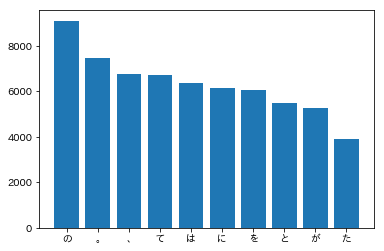

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

word_freq_top10 = word_freq[:10]
words = [t[0] for t in word_freq_top10]
freqs = [int(t[1]) for t in word_freq_top10]

plt.bar(words, freqs)
plt.show()

## 38. ヒストグラム

単語の出現頻度のヒストグラム（横軸に出現頻度，縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け．

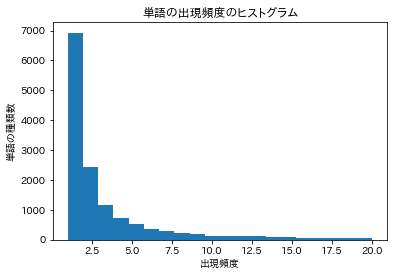

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

freqs = [int(t[1]) for t in word_freq]

plt.hist(freqs, range=(1,20), bins=20)
plt.title("単語の出現頻度のヒストグラム")
plt.xlabel("出現頻度")
plt.ylabel("単語の種類数")
plt.show()

## 39. Zipfの法則

単語の出現頻度順位を横軸，その出現頻度を縦軸として，両対数グラフをプロットせよ．

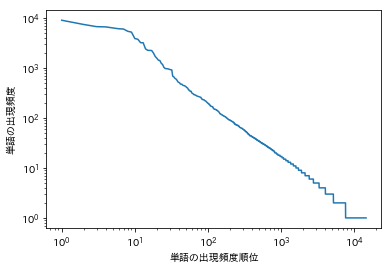

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("単語の出現頻度順位")
plt.ylabel("単語の出現頻度")
plt.xscale('log')
plt.yscale('log')

plt.plot(range(1, len(freqs)+1), freqs)
plt.show()